In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(ggplot2)
options(repr.matrix.max.rows = 6)
install.packages('kknn')
library("kknn")
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

ERROR: Error in library(GGally): there is no package called ‘GGally’


## **Introduction**

Vancouver is reported to be the least affordable housing market in North America (Grigoryeva & Ley, 2019). Fluctuated with the health of the economy, housing prices are based on a variety of factors, such as size of the property and the installation status of amenities. However, there should always be things about a home that intrinsically make it higher value than others. **Removing economic fluctuations, what makes a house worth more than another, and how can we predict the value of a house?**

*Goal*: Predict housing prices based on its size, with consideration of additional attributes (bedrooms, bathroom, stories, and parking).

To address this question, we will be using the Housing Price Prediction dataset from Kaggle. This comprehensive data set includes 13 key attributes of residential properties, covering property size, architectural features, the presence of amenities, and infrastructures within the house. Our focus will be on the quantitative variables, such as areas, bedrooms, bathroom, stories, and parking. Analyzing these non-economic factors provides deeper insight into their influence on price predictions, potentially helping future homebuyers in budget planning.


**Methodology**

We will assess both KNN and linear regression models to determine the most accurate one. Both of the regression models predict the price of the homes given their predictor variables, the main one being the area of the home, in order to find the model which will yield the most accurate result given the data provided.  As is standard in the creation of a model, the dataset is initially split into a training and testing data frame.  The ideal number of nearest neighbours will need to be tuned for the KNN algorithm, and only afterwards will we fit the model onto our training set and predict its accuracy while comparing the predicted values of the predicted variables, and the original variables of the test set. 


In [2]:
url <- "https://raw.githubusercontent.com/Xela-debug/datasets/main/Housing.csv"
housing_df <- read_csv(url)

set.seed(2023)
housing_split <- initial_split(housing_df, prop = 0.75, strata = price)
housing_test <- testing(housing_split)
housing_train <- training(housing_split)

# Taking a glance into the training data set
head(housing_train)
tail(housing_train)

Rows: 545 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): mainroad, guestroom, basement, hotwaterheating, airconditioning, pr...
dbl (6): price, area, bedrooms, bathrooms, stories, parking

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
3430000,3185,2,1,1,yes,no,no,no,no,2,no,unfurnished
3430000,3850,3,1,1,yes,no,no,no,no,0,no,unfurnished
3430000,2145,3,1,3,yes,no,no,no,no,0,yes,furnished
3430000,2610,3,1,2,yes,no,yes,no,no,0,yes,unfurnished
3430000,1950,3,2,2,yes,no,yes,no,no,0,yes,unfurnished
3395000,3450,3,1,1,yes,no,yes,no,no,2,no,unfurnished


price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
5866000,4800,3,1,1,yes,yes,yes,no,no,0,no,unfurnished
5810000,5828,4,1,4,yes,yes,no,no,no,0,no,semi-furnished
5810000,5200,3,1,3,yes,no,no,no,yes,0,no,semi-furnished
5810000,4800,3,1,3,yes,no,no,no,yes,0,no,unfurnished
5803000,7000,3,1,1,yes,no,yes,no,no,2,yes,semi-furnished
5775000,6000,3,2,4,yes,no,no,no,yes,0,no,unfurnished


In [3]:
# Checking for NA values
housing_check_na <- housing_train |>
    summarize(check_for_na = sum(is.na(housing_train)))

housing_check_na

check_for_na
<int>
0


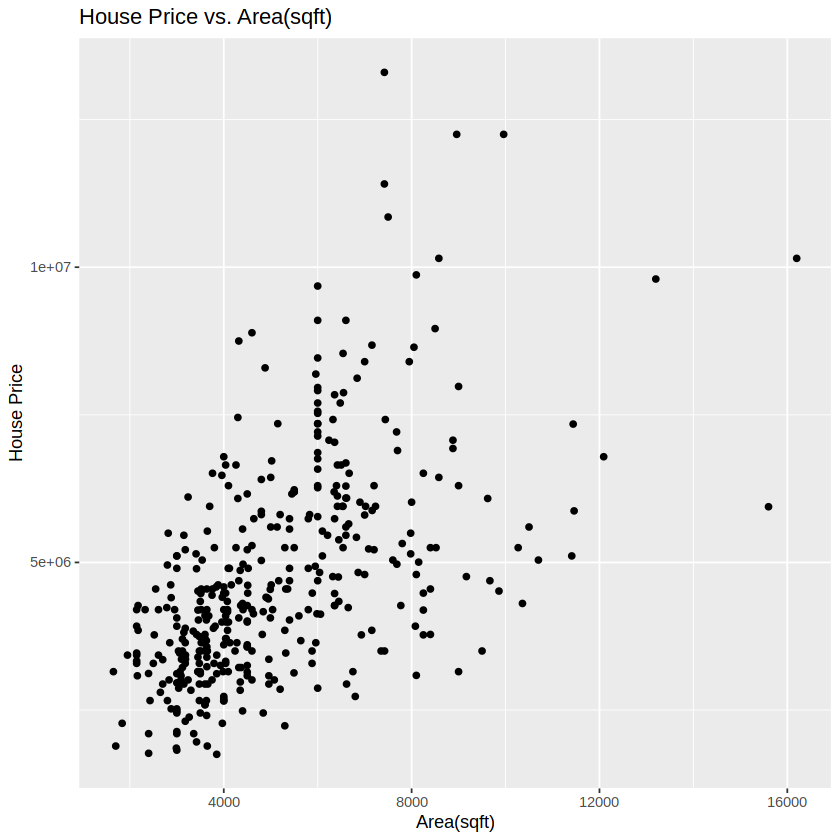

In [4]:
# Scatterplot for price vs. area
housing_plot <- housing_train |>
    ggplot(aes(x = area, y = price)) +
    geom_point() +
    labs(x = "Area(sqft)", y = "House Price")+
    ggtitle("House Price vs. Area(sqft)")

housing_plot

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




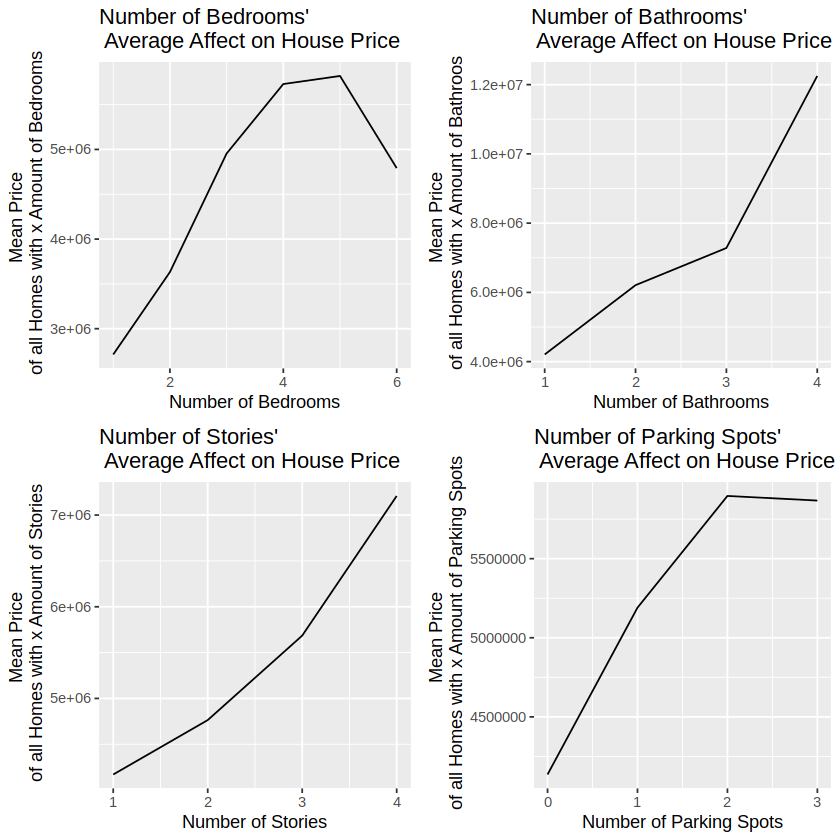

In [5]:
# Examining the average affect of other quantitative datas on house price, including numbers of bedrooms, bathrooms, stories, parking spots.

mean_housing_df <- housing_df |>
    group_by(bedrooms) |>
    mutate(mean_price_per_bedroom = mean(price))
bedrooms_plot <- mean_housing_df |>
    ggplot(aes(x = bedrooms, y = mean_price_per_bedroom)) +
        geom_line() +
        labs(title = "Number of Bedrooms'\n Average Affect on House Price", x = "Number of Bedrooms", y = "Mean Price \n of all Homes with x Amount of Bedrooms")

mean_housing_df <- housing_df |>
    group_by(bathrooms) |>
    mutate(mean_price_per_bathroom = mean(price))
bathrooms_plot <- mean_housing_df |>
    ggplot(aes(x = bathrooms, y = mean_price_per_bathroom)) +
        geom_line() +
        labs(title = "Number of Bathrooms'\n Average Affect on House Price", x = "Number of Bathrooms", y = "Mean Price \n of all Homes with x Amount of Bathroos")

mean_housing_df <- housing_df |>
    group_by(stories) |>
    mutate(mean_price_per_stories = mean(price))
stories_plot <- mean_housing_df |>
    ggplot(aes(x = stories, y = mean_price_per_stories)) +
        geom_line() +
        labs(title = "Number of Stories'\n Average Affect on House Price", x = "Number of Stories", y = "Mean Price \n of all Homes with x Amount of Stories")

mean_housing_df <- housing_df |>
    group_by(parking) |>
    mutate(mean_price_per_parking = mean(price))
parking_plot <- mean_housing_df |>
    ggplot(aes(x = parking, y = mean_price_per_parking)) +
        geom_line() +
        labs(title = "Number of Parking Spots'\n Average Affect on House Price", x = "Number of Parking Spots", y = "Mean Price \n of all Homes with x Amount of Parking Spots")

#combining the graphs for clearer visualization
install.packages("gridExtra")
library(gridExtra)
grid.arrange(bedrooms_plot, bathrooms_plot, stories_plot, parking_plot, nrow = 2)

**Observations:** As expected, all graphs indicate that housing price increases as the quantitative variable (numbers of bedrooms, bathrooms, stories, parking spots)increase. However, each trends contains interesting variations that are worth looking into:

- **Bedrooms:** peak price is observed at 5 bedrooms, followed by a decrease thereafter
- **Bathrooms:** price increases significantly with more than 3 bathrooms 
- **Stories:** increase of prices rises steadily
- **Parking:** maximum price observed at 2 parking spots

These observations mirror insights from a study on housing price determinants in the USA. The research indicates that the square footage of a property exerts the most significant impact on housing price, closely followed by its location, and its number of bathrooms and bedrooms (Jafari & Akhavian, 2019). Remarkably, our findings align closely with these established research conclusions. Moreover, the study indicates that neighborhood characteristics, such as distance to open spaces and shopping malls, exert a comparatively weaker influence on housing prices. This conclusion further justified our effective choices of variables.


## Data Analysis

We will assess both KNN and linear regression models to determine the most accurate one. Both of the regression models predict the price of the homes given their predictor variables, the main one being the area of the home, in order to find the model which will yield the most accurate result given the data provided.  As is standard in the creation of a model, the dataset is initially split into a training and testing data frame.  The ideal number of nearest neighbours will need to be tuned for the KNN algorithm, and only afterwards will we fit the model onto our training set and predict its accuracy while comparing the predicted values of the predicted variables, and the original variables of the test set.  

In [ ]:
# Insert KNN Regression

In [ ]:
# Insert Linear Regression

In [ ]:
# Code to show the difference in RMSPE

With a lower RMSPE, the KNN regression model is a better predictor for this dataset.

In [ ]:
# Insert KNN Visualization

## Discussion

**Findings**

From the comparison of the RMSE of both models, our findings showed that the KNN model was significantly more accurate than the linear model, which is in stark contrast to our initial expectations of the results going into this from a quick look at the visualization of the price in relation to the area of the homes.  

Upon a secondary examination of the visualization, the variables still seem to have a linear relationship, albeit, not actually as strong as anticipated, with the data scattering heavily the larger the price and area gets, with a multitude of outliers presenting themselves.

The findings of the secondary examination seem to be echoed by the descriptions of the linear model’s shortcomings.  Namely, that the model is inefficient at predicting the values of variables which have a nonlinear relationship, as well as its susceptibility to outliers, far greater than the KNNs.  The weak linearity within the dataset as a whole meant that although the model has many strengths, such as a calculable prediction slope, the lack of a need to tune its parameters, the ability to make predictions outside of the range of the data provided and an affinity for linear data, those very factors above overshadowed the model’s potential, as reflected in the results shown.

On the other hand, where the linear model failed was the KNN’s strong suit.  That being, a particular resistance to outliers and the absence of assumptions on the dataset required to work at its finest.  These are the deciding factors which have allowed the KNN regression model to overtake the linear regression model in terms of accuracy, and in turn yield a smaller RMSE.  Yet, this model doesn’t come without its weaknesses, such as being confined to the range of the training data, and growing more inaccurate past a threshold as the predictor values increase.  Regardless of these facts, they don’t present themselves in the dataset as saliently, they hadn’t become a hindrance to the accuracy of the model, and allowed the KNN model to overtake the linear regression model.

**Expected Outcomes**

We anticipated that our analysis would confirm that certain quantitative variables, such as property size and number of bedrooms, would have a positive relationship with the value of the house. This was true. As these quantitative variables increased, so did the price of a house.

Additionally, we expected that the presence of certain categorical values such as parking and accessibility to the mainroad would generally lead to an increase in the housing price. However, subjective factors like the buyer's perception of the value of these amenities could affect how much of an increase there is. It was difficult factoring these subjectivities into the model, as it made some observations inconsistent. However, these findings are significant because they offer future house owners a more precise understanding of the factors influencing house prices.

It was unexpected that the KNN regression model had a lower RMSPE than the linear regression model. We had assumed that with the heavy amount of quantitative data and the fact that the predicted variable was continuous, that a linear regression would be more suitable. However, KNN regression may have been more effective as the data set had very weak linearity. There were a significant amount of outliers which made the linear regression’s output weaker. 

**Impact of Findings**

With this model, we can more accurately predict unknown housing prices and find out if listed houses are either undervalued or overvalued. This can be helpful to both sellers and buyers.

For sellers, this model can act as a benchmark for what price to list a house at. Even in the presence of a realtor, the model can act as a second opinion and give sellers additional peace of mind if both the realtor and model agree on a fair price. 

For buyers, this model can help screen for good deals. If one is looking for a house with three bedrooms and the listed price is lower than what the model outputs, it may be the best option on the market. It could also act as an indicator for buyers to do their due diligence. There’s a chance that the house is listed below its supposed true value because there is something wrong with the house, i.e. poor foundation. The model acts as a professional in pricing whilst the buyer shops for houses, ultimately supporting them throughout the entire process.

The limitations of the KNN model however, include an inability to see how much one factor affects the housing price. Had the linear regression model been a better predictor, we could have gained additional insight into what factors heavily influence the price, and used those insights to power buyers/sellers decisions. For example, if the number of bedrooms significantly increased the listing price, it could be worth it for a seller to repurpose an empty room into a bedroom. 

There are additional questions that could be explored for further understanding of housing prices:

- Is it cheaper to buy a house with amenities included or buy one without and install yourself?
- What other variables can impact a house(e.g. age of the house, color)?
- While the study suggests a weaker impact of neighborhood characteristics, could specific neighborhood features or amenities in Vancouver exhibit a stronger correlation with housing prices compared to broader area analysis?


In [6]:
# Optional section for amenities

**References**

Grigoryeva, Idaliya, and David Ley. 2019. “The Price Ripple Effect in the Vancouver Housing Market.” Urban Geography 40 (8): 1168–90. https://doi.org/10.1080/02723638.2019.1567202.

Jafari, Amirhosein , and Reza Akhavian . 2019. 
“Driving Forces for the US Residential Housing Price: A Predictive Analysis.” June 18, 2019. https://www.emerald.com/insight/content/doi/10.1108/BEPAM-07-2018-0100/full/html.
